Motivacija: primer volumsko gretih palic, ki jih hladimo z vodo, so lahko npr. 
uranove palice v jedrskem reaktoju v Krškem. Gretje je posledica jedrskih reakcij.


$$\frac{\partial}{\partial x}\left( \frac{\partial T}{\partial x}\right)-n^2(T-T_{\infty}) + q=0$$
                                                                        

Ilustracija mreže v 1D:
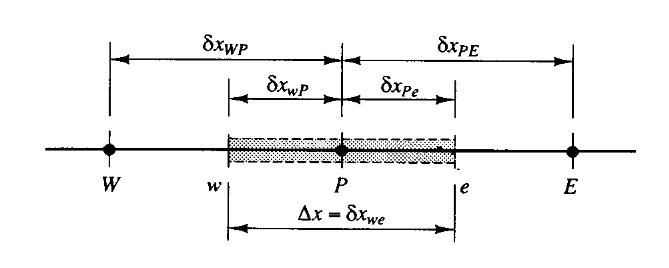
    

Integracija po kontronih volumnih:
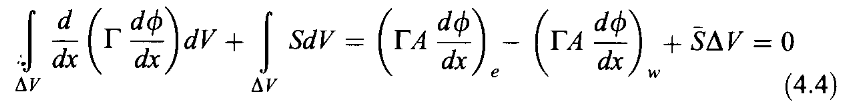

Diskretizirane enačbe za vsako točko v notranjosti:
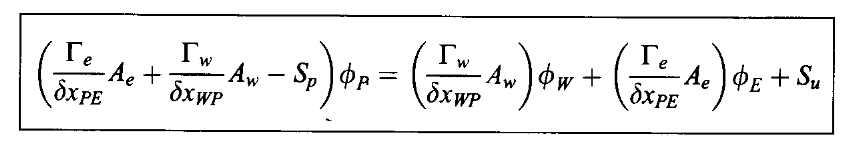

Diskretizacijski koeficienti:
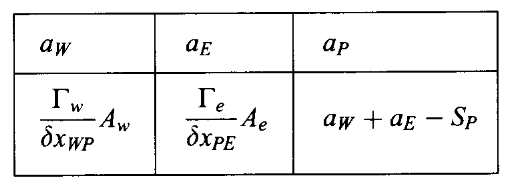

In [ ]:
# -*- coding: utf-8 -*-

#FVM difuzija 1D, a demonstration of FVM for diffusion in 1D
#Copyright (C) 2020  Boštjan Mavrič, Matjaž Zadnik
#
#This program is free software: you can redistribute it and/or modify
#it under the terms of the GNU General Public License as published by
#the Free Software Foundation, either version 3 of the License, or
#(at your option) any later version.
#
#This program is distributed in the hope that it will be useful,
#but WITHOUT ANY WARRANTY; without even the implied warranty of
#MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#GNU General Public License for more details.
#
#You should have received a copy of the GNU General Public License
#along with this program.  If not, see <http://www.gnu.org/licenses/>.

from __future__ import division # omogoči ne-celoštevilsko deljenje z znakom /
import matplotlib.pyplot as plt # knjižnica za risanje grafov
import numpy as np # knjižnica za matematične funkcije in linearno algebro
from scipy.linalg import solve_banded # naprednejše matematične rutine

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual


def FVM1D_Solve(N, Levi_rob, Desni_rob, n2, q):
    # 1D temperaturni profil palice: -k*d^2T/dx^2+q=n^2(T-T_inf)

    # Določimo vrsto robnih pogojev
    #Levi_rob='Dirichlet'
    #Levi_rob='Neumann'
    #Levi_rob='Robin'
    #Desni_rob='Dirichlet'
    #Desni_rob='Neumann'
    #Desni_rob='Robin'


    
    # Snovni parametri
    k=1000 # [W/m/K] koeficient toplotne prevodnosti
    #q=1*10**6 # [W/m^3] prostorninska generacija toplote
    h=0 # [W/m^2/K] koeficient toplotne prestopnosti
    Tinf=20 # [^oC] temperatura hladilne tekočine



    # Geometrijski parametri
    A=10**(-3) # [m^2] presek palice
    L=1 # [m] dolžina palice
    P=2*np.sqrt(np.pi*A) # obseg palice, če je ta okroglega preseka


    #n2=0 # h*P/A/k [1/m^2] parameter, ki meri vpliv konvekcijskega toka okoliške tekočine 
    # v primerjavi z vplivom robnih pogojev


    # Diskretizacija
    #N=5 # število mrežnih točk
    dx=L/N # [m] krajevni korak

    # Koeficienti sistema diferenčnih enačb za mrežne točke od 2 do N-1
    aE=1/dx
    aW=1/dx
    Sp=0
    Su=0

    # + izvori toplote
    Su=Su+q/k*dx

    # + gretje/hlajenje palice s konvekcijo okoliške tekočine
    Su=Su+n2*dx*Tinf
    Sp=Sp-n2*dx

    aP=aE+aW-Sp

    # Matrika sistema brez upoštevanja robnih pogojev
    d=aP*np.ones(N) # diagonala
    s=-aW*np.ones(N-1) # spodnja obdiagonala
    z=-aE*np.ones(N-1) # zgornja obdiagonala

    b=Su*np.ones(N) # vektor izvorov


    ########## ROBNI POGOJ NA LEVEM ROBU #####################################

    if Levi_rob=='Dirichlet':
        TA=100 # [^oC] ... temperatura levega roba

        # Koeficienti za robno točko
        aE=1/dx
        aW=0
        Su=2/dx*TA
        Sp=-2/dx

        # + izvori toplote
        Su=Su+q/k*dx 

        # + vzdolžno gretje/hlajenje palice s konvekcijo
        Su=Su+n2*dx*Tinf 
        Sp=Sp-n2*dx

        aP=aE+aW-Sp

        # popravimo matrične vrednosti za robne točke
        d[0]=aP
        b[0]=Su


    if Levi_rob=='Neumann':
        jA=0 # [W/m^2] gostota toka skozi levi rob   

        # Koeficienti
        aE=1/dx
        aW=0
        Sp=0
        Su=jA/k

        # + izvori toplote
        Su=Su+q/k*dx 

        # + vzdolžno gretje/hlajenje palice s konvekcijo
        Su=Su+n2*dx*Tinf 
        Sp=Sp-n2*dx

        aP=aE+aW-Sp

        # popravimo matrične vrednosti za robne točke
        d[0]=aP
        b[0]=Su

    if Levi_rob=='Robin':
        hA=10. # [W/m^2/K] koeficient toplotne prestopnosti na levem robu
        TinfA=80 # [^oC] temperatura hlajenja levega roba

        # Koeficienti
        aE=1/dx
        aW=0
        Sp=-hA/k
        Su=hA/k*TinfA

        Su=Su+q/k*dx

        Su=Su+n2*dx*Tinf
        Sp=Sp-n2*dx

        aP=aE+aW-Sp

        d[0]=aP
        b[0]=Su

    ########## ROBNI POGOJ NA DESNEM ROBU #####################################

    if Desni_rob=='Dirichlet':   
        TB=200 # [^oC] ... temperatura desnega roba "

        # Koeficienti
        aE=0
        aW=1/dx
        Su=2/dx*TB
        Sp=-2/dx

        # + izvori toplote
        Su=Su+q/k*dx

        # + vzdolžno gretje/hlajenje palice s konvekcijo okoliške tekočine
        Su=Su+n2*dx*Tinf
        Sp=Sp-n2*dx

        aP=aE+aW-Sp

        d[N-1]=aP
        b[N-1]=Su


    if Desni_rob=='Neumann':
        jB=10 # [W/m^2] gostota toka skozi desni rob"

        # Koeficienti
        aE=0
        aW=1/dx
        Sp=0
        Su=-jB/k

        # + izvori toplote
        Su=Su+q/k*dx

        # + vzdolžno gretje/hlajenje palice s konvekcijo okoliške tekočine
        Su=Su+n2*dx*Tinf
        Sp=Sp-n2*dx

        aP=aE+aW-Sp

        d[N-1]=aP
        b[N-1]=Su


    if Desni_rob=='Robin':
        hB=10 # [W/m^2/K] koeficient toplotne prestopnosti na desnem robu
        TinfB=80  # [^oC] temperatura hlajenja desnega roba

        # Koeficienti
        aE=0
        aW=1/dx
        Sp=-hB/k
        Su=hB/k*TinfB


        # + izvori toplote
        Su=Su+q/k*dx

        # + vzdolžno gretje/hlajenje palice s konvekcijo okoliške tekočine
        Su=Su+n2*dx*Tinf
        Sp=Sp-n2*dx

        aP=aE+aW-Sp 

        d[N-1]=aP
        b[N-1]=Su


    #### Rešimo sistem enačb AT=b z algoritmom, ki upošteva tridiagonalno zgradbo matrike A ###
    ## Algoritem je skopiran iz githuba, profil uporabnika je ofan666
    def TDMAsolver(a, b, c, d):
        '''
        TDMA solver, a b c d can be NumPy array type or Python list type.
        refer to http://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm
        and to http://www.cfd-online.com/Wiki/Tridiagonal_matrix_algorithm_-_TDMA_(Thomas_algorithm)
        '''
        nf = len(d) # number of equations
        ac, bc, cc, dc = map(np.array, (a, b, c, d)) # copy arrays
        for it in range(1, nf):
            mc = ac[it-1]/bc[it-1]
            bc[it] = bc[it] - mc*cc[it-1] 
            dc[it] = dc[it] - mc*dc[it-1]

        xc = bc
        xc[-1] = dc[-1]/bc[-1]

        for il in range(nf-2, -1, -1):
            xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]

        return xc

    T=TDMAsolver(s, d, z, b)


    #### PREDSTAVITEV PROFILA ###############################################

    # Mreža točk za risanje grafa
    x_tab=np.array([dx*i for i in range(N)]) # Python avtomatsko začne šteti z 0!
    x_tab=x_tab+dx/2


    # Graf temperaturnega profila    
    plt.plot(x_tab,T,'bo')
    plt.xlim(0,N*dx)
    plt.xlabel('Razdalja $x$ (m)')
    plt.ylabel('$T$ ($^{o}$C)')
    plt.title('Temperaturni profil')

In [ ]:
N_slider = widgets.IntSlider(min=5, max=50, step=5, value=5)
l_inter = widgets.Dropdown(options=['Dirichlet','Neumann', 'Robin'], 
                           value='Dirichlet', 
                           description='r. p. na levi')
d_inter = widgets.Dropdown(options=['Dirichlet','Neumann', 'Robin'], 
                           value='Dirichlet', 
                           description='r. p. na desni')
n_slider = widgets.FloatSlider(min=0, max=10, step=0.1, value=0)
q_slider = widgets.FloatSlider(min=0, max=1e6, step=1e6, value=1e6)
w=widgets.interactive(FVM1D_Solve,
                      N=N_slider, 
                      Levi_rob=l_inter,
                      Desni_rob=d_inter,
                      n2=n_slider,
                      q=q_slider
                     )
display(w)
